In [19]:
import os
import re
import joblib
from functools import partial
from collections import Counter

from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pprint import pprint
import pyLDAvis
import pyLDAvis.sklearn

dataroot = os.path.join(".")
outroot = os.path.join(".")

pyLDAvis_outpath = os.path.join(outroot, "view", "data.html")
os.makedirs(os.path.join(outroot, "view"), exist_ok=True)

In [2]:
# The csv files containing the data
train_clean_100_path = os.path.join(dataroot, "data", "train-clean-100.csv")
dev_clean_path = os.path.join(dataroot, "data", "dev-clean.csv")
test_clean_path = os.path.join(dataroot, "data", "test-clean.csv")

# Read the csv files
train_df = pd.read_csv(train_clean_100_path, index_col=0)
dev_df = pd.read_csv(dev_clean_path, index_col=0)
test_df = pd.read_csv(test_clean_path, index_col=0)

train_df =  pd.DataFrame({"TEXT": train_df["REAL TEXT"], "BOOK": train_df["BOOK TITLE"], "DURATION": train_df["DURATION"]})
dev_df = pd.DataFrame({"TEXT": dev_df["TEXT"], "BOOK": dev_df["BOOK TITLE"], "DURATION": dev_df["DURATION"]})
test_df = pd.DataFrame({"TEXT": test_df["TEXT"], "BOOK": test_df["BOOK TITLE"], "DURATION": test_df["DURATION"]})

# Merge data in one dataframe
df = pd.concat([train_df, dev_df, test_df])

# Now we can see we have the content of the book, the title and the duration
df.head()

,TEXT,BOOK,DURATION
0,TILL THEY WOULD FINALLY CIRCLE ROUND AND ROUND...,"The Life of Hon. William F. Cody, Known as Buf...",17.67
1,AS CINCINNATUS OR CORNELIA NOW TO SUCH A QUIET...,"Divine Comedy, Longfellow's Translation, Complete",25.10
2,LOUISE AND BETH HAVING AT LAST FULL KNOWLEDGE ...,Aunt Jane's Nieces,17.11
3,MODE BEARD THE OYSTERS AND SCALD THEM IN THEIR...,The Book of Household Management,5.79
4,SHE SAID SHE WAS NOT ABSOLUTELY CERTAIN OF THE...,The Professor,7.95


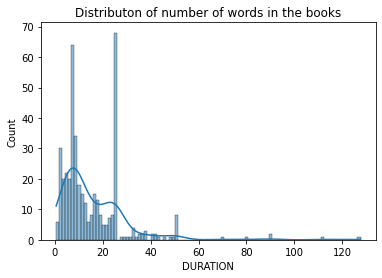

,DURATION
count,422.000000
mean,15.754858
std,14.565170
min,0.540000
25%,7.397500
50%,10.590000
75%,24.840000
max,127.620000


In [5]:
# Lets seee the distribution of the lengths of each sample book
sns.histplot(df, x='DURATION', kde=True, bins=100)
plt.title("Distributon of number of words in the books")
plt.show()
df.describe()

In [7]:
# First lets remove the books that are too long or too short from our data using the z score
df = df[(np.abs(stats.zscore(df['DURATION'])) < 3)]

df.head()

,TEXT,BOOK,DURATION
0,TILL THEY WOULD FINALLY CIRCLE ROUND AND ROUND...,"The Life of Hon. William F. Cody, Known as Buf...",17.67
1,AS CINCINNATUS OR CORNELIA NOW TO SUCH A QUIET...,"Divine Comedy, Longfellow's Translation, Complete",25.10
2,LOUISE AND BETH HAVING AT LAST FULL KNOWLEDGE ...,Aunt Jane's Nieces,17.11
3,MODE BEARD THE OYSTERS AND SCALD THEM IN THEIR...,The Book of Household Management,5.79
4,SHE SAID SHE WAS NOT ABSOLUTELY CERTAIN OF THE...,The Professor,7.95


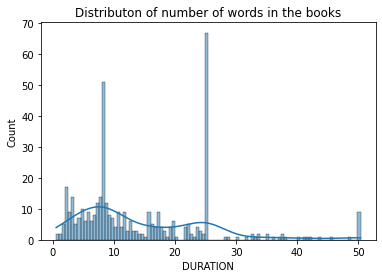

,DURATION
count,416.000000
mean,14.611995
std,10.845341
min,0.540000
25%,7.317500
50%,10.480000
75%,23.920000
max,50.340000


In [8]:
# Lets seee the distribution of the lengths of each sample book
sns.histplot(df, x='DURATION', kde=True, bins=100)
plt.title("Distributon of number of words in the books")
plt.show()
df.describe()

In [9]:
# helper functions to normalize the words in the books
# Used to remove short words. how short is a short words
_short = 2

# Used to remove stopwords from the english language
_more_stopwords = set([
    # interjections
    "oh", "ah",
    # useless
    "yes", "no",
    # archaic terms: they, you, triplet, to do, you
    "thy", "thou", "thrin", "didst", "thee"
])
_stopwords = set(stopwords.words('english')) | _more_stopwords

# Used to lemmatize words that are either adj, nouns or verbs
# depending on _pos_tags otherwise it does nothing.
_lemmatizer = WordNetLemmatizer()
_pos_tags = ["a", "n", "v"]

# Used for min/max filering. CountVectorizer removes words 
# that have a frequency higher that max_df. It also removes 
# words that appear in less documents than min_df.
_max_df = 0.50
_min_df = 5

# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
# Used to decontract words that contain "'".
def decontract(phrase: str):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def is_not_short(word):
    return len(word) > _short

def not_in_stopwords(word):
    return word not in _stopwords

def lemmatize(pair):
    word, pos = pair
    pos = pos[0].lower()
    if pos not in _pos_tags:
        return word
    return _lemmatizer.lemmatize(word, pos=pos)

def document_analyzer(book: str):
    book = str.lower(book)
    book = decontract(book)
    words = word_tokenize(book)
    words = list(filter(is_not_short, words))
    words = list(filter(not_in_stopwords, words))
    words = list(map(lemmatize, pos_tag(words)))
    return words

In [10]:
vectorizer = CountVectorizer(analyzer=document_analyzer, min_df=_min_df, max_df=_max_df)
X = vectorizer.fit_transform(df["TEXT"].to_list())

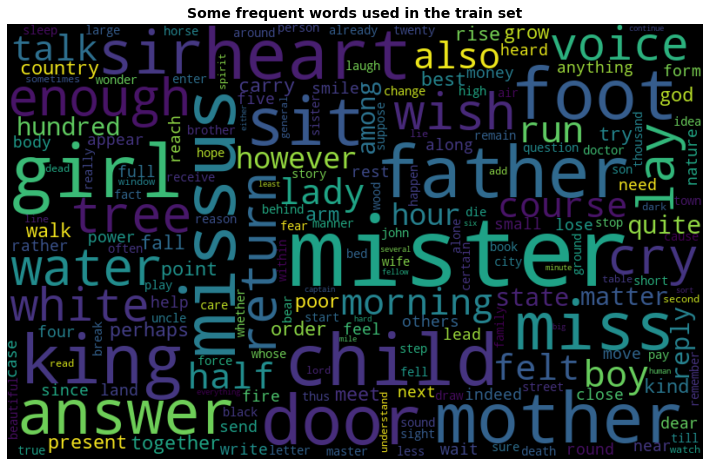

In [14]:
# Now lets visualize a word cloud of our books
wordcloud = WordCloud(width=800, height=500, max_font_size=110).generate_from_frequencies(dict(zip(vectorizer.get_feature_names(), X.toarray().sum(axis=0))))
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in the train set", weight='bold', fontsize=14)
plt.show()

In [15]:
parameters = {'n_components': range(5, 21, 2)}

lda = LatentDirichletAllocation(max_iter=10, learning_method='online', n_jobs=-1)
clf = GridSearchCV(lda, parameters, verbose=2)

clf.fit(X)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .....................................n_components=5; total time=  18.6s
[CV] END .....................................n_components=5; total time=   2.3s
[CV] END .....................................n_components=5; total time=   1.9s
[CV] END .....................................n_components=5; total time=   2.2s
[CV] END .....................................n_components=5; total time=   2.7s
[CV] END .....................................n_components=7; total time=   2.2s
[CV] END .....................................n_components=7; total time=   1.7s
[CV] END .....................................n_components=7; total time=   2.4s
[CV] END .....................................n_components=7; total time=   1.9s
[CV] END .....................................n_components=7; total time=   2.2s
[CV] END .....................................n_components=9; total time=   2.2s
[CV] END .....................................n_c

GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 n_jobs=-1),
             param_grid={'n_components': range(5, 21, 2)}, verbose=2)

In [21]:
best_lda_model = clf.best_estimator_

y_hat = best_lda_model.transform(X)

print("Best Model's Params: ", clf.best_params_)
num_topics = clf.best_params_['n_components']
print("Best Log Likelihood Score: ", clf.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(X))

Best Model's Params:  {'n_components': 5}
Best Log Likelihood Score:  -540943.553295351
Model Perplexity:  3514.660692885032


In [17]:
# Functions for printing keywords for each topic
def print_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names()

    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx), end='')
        print([words[i] for i in topic.argsort()[:-top_n - 1:-1]]) 

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(best_lda_model, vectorizer, 15) 

Topics found via LDA:
Topic 0:['king', 'tree', 'water', 'cry', 'foot', 'princess', 'mother', 'white', 'sit', 'peter', 'green', 'child', 'answer', 'boy', 'heart']
Topic 1:['power', 'also', 'nature', 'state', 'form', 'less', 'subject', 'general', 'person', 'experience', 'body', 'law', 'present', 'human', 'memory']
Topic 2:['uncle', 'john', 'major', 'bread', 'corporal', 'louise', 'girl', 'trim', 'add', 'serve', 'beth', 'wine', 'case', 'car', 'flour']
Topic 3:['mister', 'missus', 'miss', 'father', 'sir', 'girl', 'door', 'return', 'child', 'mother', 'heart', 'lady', 'however', 'foot', 'hundred']
Topic 4:['mister', 'tom', 'frank', 'jerry', 'bluff', 'line', 'graham', 'fire', 'captain', 'beat', 'wood', 'lieutenant', 'slim', 'pirate', 'trail']


In [20]:
pyLDAvis.enable_notebook()
data = pyLDAvis.sklearn.prepare(best_lda_model, X, vectorizer)
pyLDAvis.save_html(data, pyLDAvis_outpath)
data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.010047 -0.006139       1        1  63.988590
0     -0.141262 -0.019584       2        1  19.086340
1      0.208913 -0.007346       3        1  11.550375
4     -0.039366 -0.094248       4        1   2.736667
2     -0.038332  0.127316       5        1   2.638028, topic_info=         Term         Freq        Total Category  logprob  loglift
4220   mister  1146.000000  1146.000000  Default  30.0000  30.0000
6932    uncle   285.000000   285.000000  Default  29.0000  29.0000
3666     john   304.000000   304.000000  Default  28.0000  28.0000
2888     girl   633.000000   633.000000  Default  27.0000  27.0000
933   captain   293.000000   293.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
4253    money    18.750156   335.046190   Topic5  -6.0716   0.7521
2233   enough    19.625190   483.181693   Topic5  -6.0259   0.4316
3057     half    18.376877   454.258807   Topic5  -6.0917   0.4276
3271     hour    17.904506   452.121253   Topic5  -6.1177   0.4062
1479   course    17.678463   444.895038   Topic5  -6.1304   0.4096

[393 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
9         3  0.884817  abnormal
91        1  0.961493      adam
91        3  0.017170      adam
94        1  0.663304       add
94        2  0.113821       add
...     ...       ...       ...
7388      3  0.045390     write
7388      4  0.009078     write
7388      5  0.003026     write
7394      1  0.359698    yankee
7394      4  0.575517    yankee

[1155 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 5, 3])

In [ ]:
best_lda_model
topic_keywords = [([word for word, prop in best_lda_model.show_topic(t)]) for t in range(num_topics)]
topic_keywords_df = pd.DataFrame({'Topic_Keywords': topic_keywords})
topic_keywords_df

In [22]:
best_lda_model.components_

array([[ 1.37328499,  0.24286974,  0.21322999, ...,  0.25205943,
         0.2276188 ,  0.25044095],
       [ 0.21102609,  5.06643841,  0.22709958, ...,  5.76949233,
         0.93543954,  0.21730249],
       [ 0.22678911,  0.22931158,  0.22109123, ...,  0.23989453,
         0.21165276,  0.21480253],
       [ 2.58031209, 29.65912802,  8.25115336, ..., 12.83005657,
         2.88846735,  3.99676985],
       [ 1.36269515,  0.97436747,  0.21526905, ...,  0.2219683 ,
         0.66753353,  2.42687754]])